## Readme
1. 建立文件夹
2. 复制模型以及 Geometry 文件
   1. 先判断文件是否存在再复制

3. 定义传感器编号和环节的对应关系
4. 将 LMPS 坐标转换为 OpenSense 坐标 --》查找先前代码
5. 将 LMPS 文件转换为 .sto 文件

6. 运行 OpenSense 代码 --》查找先前代码
7. 在 OpenSim 中打开逆运动学结果

In [108]:
# 读取相对应的包
import os
import shutil
import pandas as pd

In [109]:
dir_path = "/Users/wangshuaibo/Library/CloudStorage/OneDrive-bsu.edu.cn/Archive/代码_OpenSense/OpenSense_Python/OpenSenseExample"
opensense_example_dir = "OpenSenseExample_Original"

In [110]:
#newfile_name = input("请输入新建文件夹名称：")
newfile_name = "20230615_LMPS_NoTorsoRightFeet"
newfile_path = os.path.join(dir_path, newfile_name)

In [111]:
# 新建文件夹
os.makedirs(newfile_path,exist_ok=True)

In [112]:
IMUData_dir = "IMUData"
file_name = "squat_100hz.csv"
file_path = os.path.join(dir_path,newfile_name,IMUData_dir,file_name)

## 读取传感器数值

In [113]:
df = pd.read_csv(file_path)
df.columns

Index(['SensorId', ' TimeStamp (s)', ' FrameNumber', ' AccX (g)', ' AccY (g)',
       ' AccZ (g)', ' GyroX (deg/s)', ' GyroY (deg/s)', ' GyroZ (deg/s)',
       ' MagX (uT)', ' MagY (uT)', ' MagZ (uT)', ' EulerX (deg)',
       ' EulerY (deg)', ' EulerZ (deg)', ' QuatW', ' QuatX', ' QuatY',
       ' QuatZ', ' LinAccX (g)', ' LinAccY (g)', ' LinAccZ (g)',
       ' Pressure (kPa)', ' Altitude (m)', ' Temperature (degC)',
       ' HeaveMotion (m)'],
      dtype='object')

<Axes: >

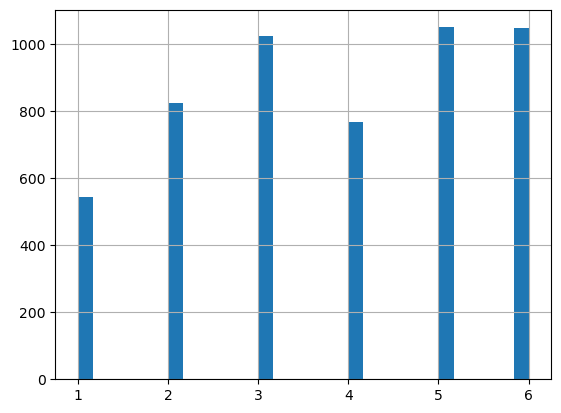

In [114]:
# 查看丢包情况
df["SensorId"].hist(bins=30)

## 转换传感器四元数坐标

In [115]:
# 定义四元数相乘函数
def quaternion_multiply(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2

    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 - x1 * z2 + y1 * w2 + z1 * x2
    z = w1 * z2 + x1 * y2 - y1 * x2 + z1 * w2

    return (w, x, y, z)

In [126]:
# 转换小蓝块坐标为opensense 坐标系格式
import numpy as np 

# 定义数值
quats = [' QuatW', ' QuatX', ' QuatY', ' QuatZ']
quats_value = df[quats].values

# 将小蓝块东北天(ENU)坐标系转换到北西天(NWU)坐标系
# 全局坐标系即沿着 Z 轴旋转90度，数值为正
# 此处应该为静态旋转即外旋？因而应该是右乘？
angle_NWU2ENU = np.pi/2
q_NWU2ENU = (np.cos(angle_NWU2ENU),0,0,np.sin(angle_NWU2ENU))
result_NWU2ENU = quaternion_multiply(quats_value.T, q_NWU2ENU)

# 将传感器方向转换为 Xsens 规定方向
# 传感器绕着 y 轴旋转 180度
angle_opensense = np.pi  # 180度等于π弧度
q_y180 = (np.cos(angle_opensense / 2), 0, np.sin(angle_opensense / 2), 0)
result_opensense = quaternion_multiply(result_NWU2ENU, q_y180)

# 将结果转换为DataFrame
tran_quats = ["trans q0","trans q1","trans q2","trans q3"]
df[tran_quats] = pd.DataFrame(list(result_opensense)).transpose()

ValueError: too many values to unpack (expected 4)

In [117]:
# 匹配传感器名称和环节部位
bodies = ["pelvis","tibia_r","femur_r","tibia_l",'femur_l','calcn_l']
sensors = [1, 5, 3, 4, 2, 6]
bodies_sensors = dict(zip(bodies,sensors))

## 提取不同传感器转换后数值

In [118]:
# 将不同传感器的数值保存在不同的列
new_df = pd.DataFrame()
series = pd.Series(dtype="float64")
for body in bodies:
    sensor_id = bodies_sensors[body]
    body_quats = [body + " " + quat for quat in tran_quats]
    # 先重置index
    temp_df = df[df['SensorId'] == sensor_id][quats].reset_index(drop=True)
    # 长度不一样只能使用 concat 连接
    new_df = pd.concat([new_df,temp_df], axis=1)

new_df.columns =  [body + " " + quat for body in bodies for quat in tran_quats]

# 新增 time 列
time = np.arange(0, new_df.shape[0]/100, 1/100)
new_df.insert(0,"time",time,)
# 去除包含空行的数据
new_df.dropna(axis=0,inplace=True)

# 保存文件
tran_file_path = os.path.splitext(file_path)[0] + "_coordinate_trans.csv"
new_df.to_csv(tran_file_path,index=False)

## 复制OpenSim 模型文件

In [119]:
# 复制模型
src_Geometry = os.path.join(dir_path,opensense_example_dir,"Geometry")
dst_Geometry = os.path.join(dir_path,newfile_name,"Geometry")

src_model = os.path.join(dir_path,opensense_example_dir,"Rajagopal_2015.osim")
dst_model = os.path.join(dir_path,newfile_name,"Rajagopal_2015.osim")

shutil.copytree(src_Geometry, dst_Geometry,dirs_exist_ok=True)
shutil.copy2(src_model, dst_model)

'/Users/wangshuaibo/Library/CloudStorage/OneDrive-bsu.edu.cn/Archive/代码_OpenSense/OpenSense_Python/OpenSenseExample/20230615_LMPS_NoTorsoRightFeet/Rajagopal_2015.osim'

In [120]:
# 设置opensim 对应的表头
# 设置表头
bodies_imu = [body+"_imu" for body in bodies]

opensim_sto_columns = "time\t"
for body_imu in bodies_imu:
    opensim_sto_columns = opensim_sto_columns + body_imu + "\t"

opensim_sto_columns = opensim_sto_columns.strip() + "\n"

In [121]:
frame_rate = 60
meatdata = f"""DataRate={frame_rate:.6f}
DataType=Quaternion
version=3
OpenSimVersion=4.4-2022-10-11-798caa8
endheader
"""
header = meatdata + opensim_sto_columns
header

'DataRate=60.000000\nDataType=Quaternion\nversion=3\nOpenSimVersion=4.4-2022-10-11-798caa8\nendheader\ntime\tpelvis_imu\ttibia_r_imu\tfemur_r_imu\ttibia_l_imu\tfemur_l_imu\tcalcn_l_imu\n'

In [122]:
old_filename = tran_file_path
newfile_path = os.path.splitext(file_path)[0] + ".sto"

In [123]:
# 先写入表头内容
with open(newfile_path,"w") as new_f:
    new_f.write(header)
# 写入四元数数据
with open(tran_file_path, "r") as old_f, open(newfile_path, "a") as new_f:
    line_index = 0
    for line in old_f:
        # 去除第一行的表头不进行记录
        line_index += 1
        if line_index > 1:
            new_line = line.split(",")
            # print(new_line)
            str_new = ""
            index = 0
            for i in new_line:
                if index % 4 == 0:
                    str_new = str_new + i.strip() + "\t"
                else:
                    str_new = str_new + i.strip() + ","
                index = index + 1
            new_f.write(str_new.strip()+"\n")